# Lung Cancer treatment demo – Part 1 

Use Deep Learning and this ​dataset​ https://luna16.grand-challenge.org/data/  to determine if the patient will be diagnosed with lung cancer.
You are given over a thousand low-dose CT images from high-risk patients in ​DICOM​ format. 
Each image contains a series with multiple axial slices of the chest cavity.
Each image has a variable number of 2D slices, which can vary based on the machine taking the scan and patient.
The DICOM files have a header that contains the necessary information about the patient id, as well as scan parameters such as the slice thickness​. ​The project should follow the guideline as: 
 
1. Pre-process the image data
2. Perform data exploration to learn as much about the data (include visualization in 2D, 3D, segmentation, bisecting images, rotation, etc.) 
3. Apply CNN with classification_report to determine the result.
4. Tune the models for better performance.
5. Using Object Localization, locate precisely the location of tumor (if positive).
6. Identify the correct measurement the size of tumor (in terms of diameter, thickness, shapes, etc.). 
7. Using test images, evaluate the performance of models. 

In [23]:
# import pydicom 
import os
import pandas as pd
import numpy
import SimpleITK as sitk
import numpy as np
import glob
import csv
import os
from sklearn.model_selection import train_test_split
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import pyplot, cm

In [238]:
pd.set_option('display.max_colwidth', -1)

# 1. Data exploration

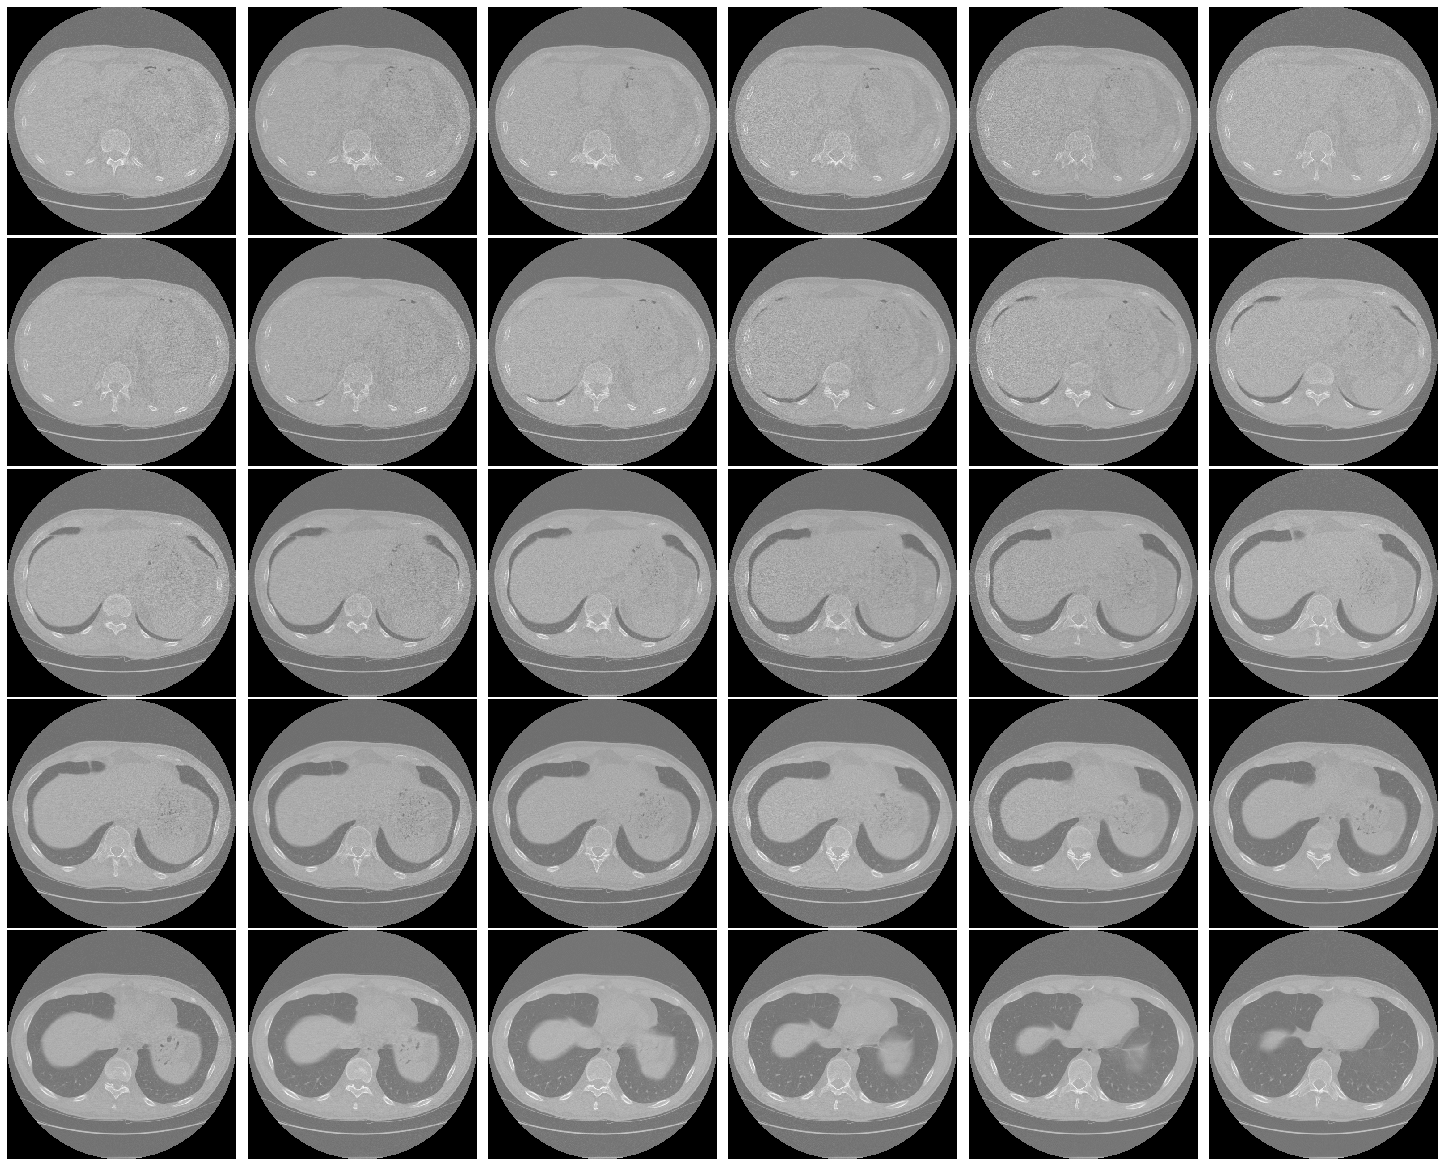

In [20]:
# import SimpleITK as sitk
# import matplotlib.pylab as plt
ct_scans = sitk.GetArrayFromImage(sitk.ReadImage("subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd", sitk.sitkFloat32))
plt.figure(figsize=(20,16))
plt.gray()
plt.subplots_adjust(0,0,1,1,0.01,0.01)
for i in range(ct_scans.shape[0]):
    if i == 30 :
        break
    plt.subplot(5,6,i+1), plt.imshow(ct_scans[i]), plt.axis('off')
    # use plt.savefig(...) here if you want to save the images as .jpg, e.g.,
plt.show()

In [7]:
ct_scans.shape[0]

121

### Get all CT files

In [24]:
PathDicom = "./subset0"
lstFilesDCM = [] 
for dirName, subdirList, fileList in os.walk(PathDicom):
    for filename in fileList:
        if ".mhd" in filename.lower():
            lstFilesDCM.append(os.path.join(dirName,filename))

In [25]:
len(lstFilesDCM)

89

In [26]:
lstFilesDCM[0]

'./subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd'

In [28]:
def load_itk_image(filename):
    itkimage = sitk.ReadImage(filename)
    numpyImage = sitk.GetArrayFromImage(itkimage)
    numpyOrigin = np.array(list(reversed(itkimage.GetOrigin())))
    numpySpacing = np.array(list(reversed(itkimage.GetSpacing())))
    return numpyImage, numpyOrigin, numpySpacing
numpyImage, numpyOrigin, numpySpacing = load_itk_image(lstFilesDCM[0])
print (numpyImage.shape)
print (numpyOrigin)
print (numpySpacing)

(121, 512, 512)
[-335.209991 -195.       -198.100006]
[2.5        0.76171899 0.76171899]


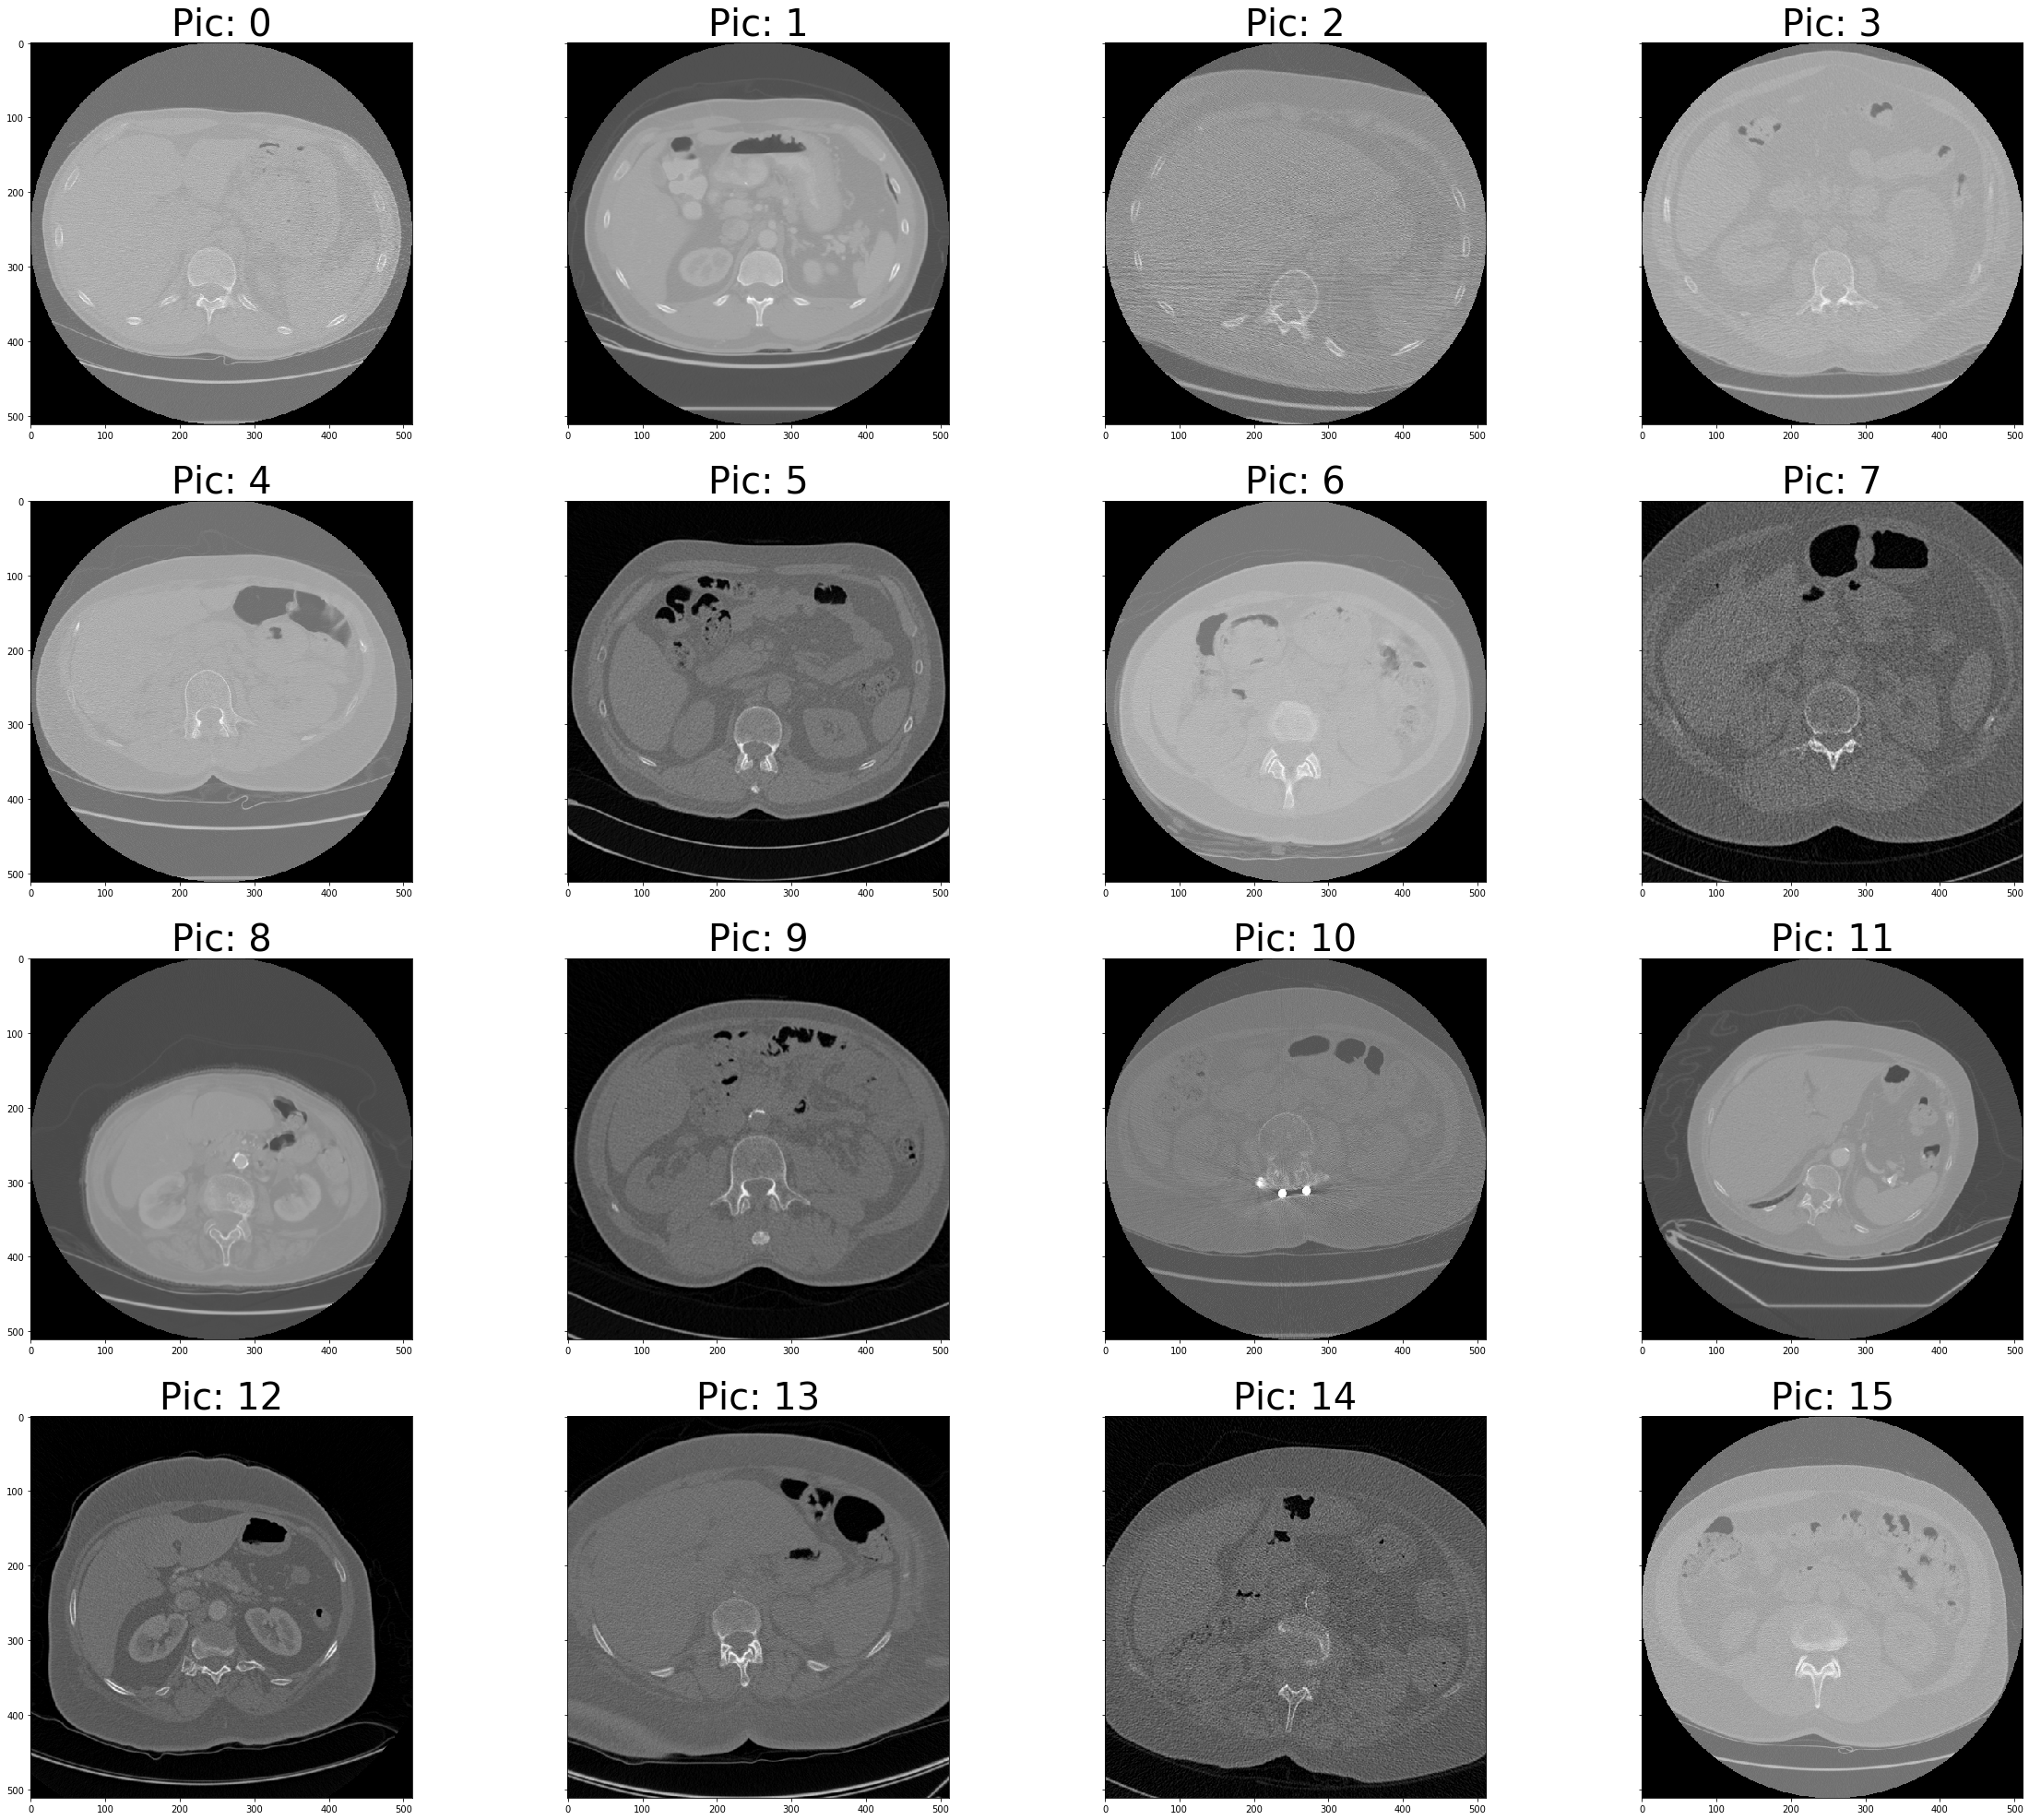

In [32]:
#   print first 16 CT pic
fig, axs = plt.subplots(4,4, figsize=(40, 35), sharey='row')
axs = axs.ravel()
for index, i in enumerate(range(0,16,1)):
    axs[index].imshow(load_itk_image(lstFilesDCM[i])[0][0])
    axs[index].set_title('Pic: '+str(i),fontsize=40)
plt.show()

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


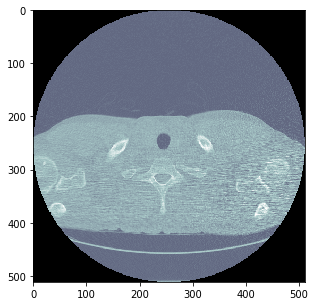

In [36]:
#  Print GIF of a CT pic
import matplotlib.animation as animation
def animate():
    fig =  plt.figure(figsize=(8,5))
    anim = plt.imshow(load_itk_image(lstFilesDCM[0])[0][0], cmap=plt.cm.bone)
    def update(i):
        anim.set_array(load_itk_image(lstFilesDCM[0])[0][i])
        return anim
    a= animation.FuncAnimation(fig, update, frames=np.arange(0, 121), interval=121)
    a.save('test.gif', writer='imagemagick', fps=15)
animate()
def display_gif(fn):
    from IPython import display
    return display.HTML('<img src="{}">'.format(fn))
display_gif('test.gif')

# plt.close

### Load candidates_V2 .csv

In [39]:
df_candidates = pd.read_csv('candidates_V2.csv')

In [40]:
df_candidates.head()

seriesuid     coordX      coordY  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  68.420000  -74.480000   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -95.209361  -91.809406   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -24.766755 -120.379294   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -63.080000  -65.740000   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  52.946688  -92.688873   

       coordZ  class  
0 -288.700000      0  
1 -377.426350      0  
2 -273.361539      0  
3 -344.240000      0  
4 -241.067872      0

In [41]:
df_candidates.shape

(754975, 5)

In [43]:
datasub0 = df_candidates[0:0]
# datasub0

In [53]:
lstFilesDCM[1]

'./subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd'

In [56]:
for i in range(df_candidates.shape[0]):
#     print("./subset0\\\\"+ df_candidates.seriesuid[i]+'.mhd')
    if ('./subset0\\\\'+ df_candidates.seriesuid[i]+'.mhd' in lstFilesDCM):
        datasub0 = datasub0.append(df_candidates.loc[i])

In [57]:
datasub0

seriesuid      coordX  \
11673   1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...  -66.383107   
11674   1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031... -132.856859   
11675   1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...   84.770000   
11676   1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...  134.805360   
11677   1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...  -87.092676   
...                                                   ...         ...   
641328  1.3.6.1.4.1.14519.5.2.1.6279.6001.566816709786...   25.821211   
641329  1.3.6.1.4.1.14519.5.2.1.6279.6001.566816709786...  -94.366707   
641330  1.3.6.1.4.1.14519.5.2.1.6279.6001.566816709786...  -86.424506   
641331  1.3.6.1.4.1.14519.5.2.1.6279.6001.566816709786... -123.850000   
641332  1.3.6.1.4.1.14519.5.2.1.6279.6001.566816709786... -103.002871   

           coordY      coordZ  class  
11673   57.143607  -60.885862      0  
11674   23.813034 -274.350845      0  
11675   66.170000 -249.880000      0  
11676   29.696241 -268.116009      0  
11677   41.722383 -208.831394      0  
...           ...         ...    ...  
641328  26.241010  -78.831834      0  
641329  49.684055 -224.514220      0  
641330 -28.625581 -141.753041      0  
641331  46.450000 -253.000000      0  
641332  38.372032 -156.612097      0  

[64785 rows x 5 columns]

In [58]:
datasub0['class'].value_counts()

0    64676
1      109
Name: class, dtype: int64

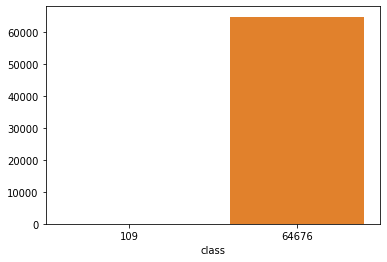

In [59]:
sns.barplot(x=datasub0['class'].value_counts(), y=datasub0['class'].value_counts().sum())

#### Make positive cancer dataframe

In [62]:
datasub0_p = datasub0[ datasub0['class'] == 1 ]

In [63]:
datasub0_p

seriesuid      coordX  \
20384   1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896... -100.709660   
22033   1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...   36.577828   
22208   1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...   45.517008   
25892   1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674...  136.297029   
56764   1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048...  146.239444   
...                                                   ...         ...   
633824  1.3.6.1.4.1.14519.5.2.1.6279.6001.534006575256...  -93.714337   
634084  1.3.6.1.4.1.14519.5.2.1.6279.6001.534083630500...  114.247667   
634178  1.3.6.1.4.1.14519.5.2.1.6279.6001.534083630500...  -87.205072   
634711  1.3.6.1.4.1.14519.5.2.1.6279.6001.534083630500...  -42.775000   
641190  1.3.6.1.4.1.14519.5.2.1.6279.6001.566816709786... -124.999831   

            coordY      coordZ  class  
20384    68.191806 -230.920000      1  
22033    77.166931 -123.632500      1  
22208    48.789231 -109.205277      1  
25892   117.290290 -182.063909      1  
56764  -161.190112 -310.777295      1  
...            ...         ...    ...  
633824   63.079562  -95.292540      1  
634084  -37.119900 -138.729667      1  
634178   56.077287 -112.332500      1  
634711   -3.325000 -114.800000      1  
641190   20.371754 -169.290000      1  

[109 rows x 5 columns]

In [218]:
datasub0_p.seriesuid.value_counts()

1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583497382954024478441    6
1.3.6.1.4.1.14519.5.2.1.6279.6001.511347030803753100045216493273    5
1.3.6.1.4.1.14519.5.2.1.6279.6001.137763212752154081977261297097    5
1.3.6.1.4.1.14519.5.2.1.6279.6001.295420274214095686326263147663    5
1.3.6.1.4.1.14519.5.2.1.6279.6001.187451715205085403623595258748    4
1.3.6.1.4.1.14519.5.2.1.6279.6001.534006575256943390479252771547    4
1.3.6.1.4.1.14519.5.2.1.6279.6001.202811684116768680758082619196    4
1.3.6.1.4.1.14519.5.2.1.6279.6001.188376349804761988217597754952    4
1.3.6.1.4.1.14519.5.2.1.6279.6001.213140617640021803112060161074    3
1.3.6.1.4.1.14519.5.2.1.6279.6001.534083630500464995109143618896    3
1.3.6.1.4.1.14519.5.2.1.6279.6001.430109407146633213496148200410    3
1.3.6.1.4.1.14519.5.2.1.6279.6001.334517907433161353885866806005    3
1.3.6.1.4.1.14519.5.2.1.6279.6001.294188507421106424248264912111    3
1.3.6.1.4.1.14519.5.2.1.6279.6001.249530219848512542668813996730    3
1.3.6.1.4.1.14519.5.

In [219]:
len(datasub0_p.seriesuid.value_counts())

55

In [70]:
def plot_nodule(row):
    itk_img = sitk.ReadImage("./subset0/"+row['seriesuid']+".mhd") 
    img_array = sitk.GetArrayFromImage(itk_img)  # z,y,x ordering
    origin_xyz = np.array(itk_img.GetOrigin())   # x,y,z  Origin in world coordinates (mm)
    spacing_xyz = np.array(itk_img.GetSpacing()) # spacing of voxels in world coor. (mm)
    center_xyz = (row['coordX'],row['coordY'], row['coordZ'])
    nodule_xyz = ((center_xyz - origin_xyz) // spacing_xyz).astype(np.int16)

    import matplotlib.patches as patches
    fig, ax = plt.subplots(1)
    ax.imshow(img_array[nodule_xyz[2]], cmap=plt.cm.gray)
    ax.add_patch(patches.Rectangle(
            (nodule_xyz[0] - 16, nodule_xyz[1]-16),   # (x,y)
            32,          # width
            32,          # height
            linewidth=1, edgecolor='r', facecolor='none'
        )
    )
    return row

In [99]:
# t= datasub0_p.seriesuid.loc[0:0]
# print(datasub0_p.iloc[0,0:1])

In [227]:
df_plot_nodule = datasub0_p[9:10]
df_plot_nodule

seriesuid  coordX  coordY  \
85487  1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583...  -86.05   16.82   

       coordZ  class  
85487  -68.38      1

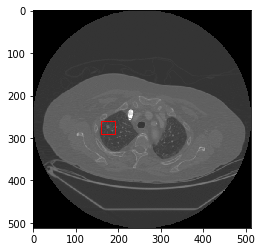

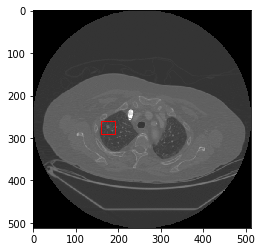

In [71]:
df_plot_nodule = df_plot_nodule.apply(plot_nodule,axis=1)

In [220]:
datasub0_n = datasub0.drop_duplicates('seriesuid', keep='last')

In [72]:
# datasub0_n = datasub0[datasub0['class']==0].head(200)

In [193]:
# datasub0_n2 = datasub0[datasub0['class']==0].head(200).groupby('seriesuid').head(200)

In [221]:
len(datasub0_n.seriesuid.value_counts())

75

In [222]:
data = datasub0_p.append(datasub0_n)

In [223]:
data.shape

(184, 5)

In [224]:
data

seriesuid      coordX  \
20384   1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896... -100.709660   
22033   1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...   36.577828   
22208   1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...   45.517008   
25892   1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674...  136.297029   
56764   1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048...  146.239444   
...                                                   ...         ...   
632921  1.3.6.1.4.1.14519.5.2.1.6279.6001.525937963993...   63.980000   
634077  1.3.6.1.4.1.14519.5.2.1.6279.6001.534006575256...  109.070000   
634788  1.3.6.1.4.1.14519.5.2.1.6279.6001.534083630500...   53.241645   
640880  1.3.6.1.4.1.14519.5.2.1.6279.6001.564534197011...   41.957463   
641332  1.3.6.1.4.1.14519.5.2.1.6279.6001.566816709786... -103.002871   

            coordY      coordZ  class  
20384    68.191806 -230.920000      1  
22033    77.166931 -123.632500      1  
22208    48.789231 -109.205277      1  
25892   117.290290 -182.063909      1  
56764  -161.190112 -310.777295      1  
...            ...         ...    ...  
632921   29.530000 -177.080000      0  
634077  -39.680000 -207.730000      0  
634788   31.488771 -157.353199      0  
640880   48.108986 -120.234968      0  
641332   38.372032 -156.612097      0  

[184 rows x 5 columns]

In [228]:
len(data.seriesuid.value_counts())

75

In [246]:
df_annotation = pd.read_csv('annotations.csv')
df_annotation.head()

seriesuid  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405   

       coordX      coordY      coordZ  diameter_mm  
0 -128.699421 -175.319272 -298.387506  5.651471     
1  103.783651 -211.925149 -227.121250  4.224708     
2  69.639017  -140.944586  876.374496  5.786348     
3 -24.013824   192.102405 -391.081276  8.143262     
4  2.441547    172.464881 -405.493732  18.545150

In [77]:
df_annotation.seriesuid.value_counts()

1.3.6.1.4.1.14519.5.2.1.6279.6001.176030616406569931557298712518    12
1.3.6.1.4.1.14519.5.2.1.6279.6001.195557219224169985110295082004     9
1.3.6.1.4.1.14519.5.2.1.6279.6001.202187810895588720702176009630     9
1.3.6.1.4.1.14519.5.2.1.6279.6001.328789598898469177563438457842     9
1.3.6.1.4.1.14519.5.2.1.6279.6001.219428004988664846407984058588     9
                                                                    ..
1.3.6.1.4.1.14519.5.2.1.6279.6001.241570579760883349458693655367     1
1.3.6.1.4.1.14519.5.2.1.6279.6001.143412474064515942785157561636     1
1.3.6.1.4.1.14519.5.2.1.6279.6001.315770913282450940389971401304     1
1.3.6.1.4.1.14519.5.2.1.6279.6001.652347820272212119124022644822     1
1.3.6.1.4.1.14519.5.2.1.6279.6001.321465552859463184018938648244     1
Name: seriesuid, Length: 601, dtype: int64

> some patients have more than 1 nodule

In [247]:
df_annotation[df_annotation['diameter_mm'] ==0 ]

Empty DataFrame
Columns: [seriesuid, coordX, coordY, coordZ, diameter_mm]
Index: []

In [131]:
df_annotation.isnull().sum()/len(df_annotation)*100

seriesuid      0.0
coordX         0.0
coordY         0.0
coordZ         0.0
diameter_mm    0.0
dtype: float64

In [158]:
# data = data.reindex(columns=['seriesuid', 'coordX', 'coordY', 'coordZ', 'class'])


In [229]:
data1 = data[['seriesuid','class' ]]

In [230]:
data1

seriesuid  class
20384   1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896...      1
22033   1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...      1
22208   1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...      1
25892   1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674...      1
56764   1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048...      1
...                                                   ...    ...
632921  1.3.6.1.4.1.14519.5.2.1.6279.6001.525937963993...      0
634077  1.3.6.1.4.1.14519.5.2.1.6279.6001.534006575256...      0
634788  1.3.6.1.4.1.14519.5.2.1.6279.6001.534083630500...      0
640880  1.3.6.1.4.1.14519.5.2.1.6279.6001.564534197011...      0
641332  1.3.6.1.4.1.14519.5.2.1.6279.6001.566816709786...      0

[184 rows x 2 columns]

In [231]:
data1['coordX'] = 0
data1['coordY'] = 0
data1['coordZ'] = 0
data1['diameter_mm'] = 0

c:\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [275]:
data1 = data1.drop_duplicates('seriesuid', keep='last')

In [276]:
data1 = data1.reset_index(drop=True)

In [277]:
data1

seriesuid  class  \
0   1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260  0       
1   1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492  0       
2   1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059  0       
3   1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987  0       
4   1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720  0       
..                                                               ... ..       
70  1.3.6.1.4.1.14519.5.2.1.6279.6001.525937963993475482158828421281  0       
71  1.3.6.1.4.1.14519.5.2.1.6279.6001.534006575256943390479252771547  0       
72  1.3.6.1.4.1.14519.5.2.1.6279.6001.534083630500464995109143618896  0       
73  1.3.6.1.4.1.14519.5.2.1.6279.6001.564534197011295112247542153557  0       
74  1.3.6.1.4.1.14519.5.2.1.6279.6001.566816709786169715745131047975  0       

    coordX  coordY  coordZ  diameter_mm  
0   0.0     0.0     0.0     0.0          
1   0.0     0.0     0.0     0.0          
2   0.0     0.0     0.0     0.0          
3   0.0     0.0     0.0     0.0          
4   0.0     0.0     0.0     0.0          
..  ...     ...     ...     ...          
70  0.0     0.0     0.0     0.0          
71  0.0     0.0     0.0     0.0          
72  0.0     0.0     0.0     0.0          
73  0.0     0.0     0.0     0.0          
74  0.0     0.0     0.0     0.0          

[75 rows x 6 columns]

In [278]:
#  copy data from  X, Y, Z,diameter_mm from   df_annotation
def fill_Data(row):
    _seriuid = row.seriesuid
    _coordX = row.coordX
    _coordY = row.coordY
    _coordZ = row.coordZ
    _diameter_mm  = row.diameter_mm
    
    if(_coordX == 0 ) :
        print("==============================================")
        return row
#     print(_seriuid)
    for index, row1 in data1.iterrows():
        if str(_seriuid) == str(row1['seriesuid']):
            
#             row1['coordX'] = _coordX
#             row1['coordY'] = _coordY
#             row1['coordZ'] = _coordZ
#             row1['diameter_mm']  = _diameter_mm
            data1.loc[index, 'coordX'] = _coordX
            data1.loc[index, 'coordY'] = _coordY
            data1.loc[index, 'coordZ'] =  _coordZ
            data1.loc[index, 'diameter_mm'] = _diameter_mm
            break
    return row

In [279]:
df_annotation = df_annotation.apply(fill_Data, axis=1)

In [280]:
data1[data1['coordX'] > 0]

seriesuid  class  \
2   1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059  0       
3   1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987  0       
5   1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565  0       
7   1.3.6.1.4.1.14519.5.2.1.6279.6001.126264578931778258890371755354  0       
8   1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912  0       
10  1.3.6.1.4.1.14519.5.2.1.6279.6001.130438550890816550994739120843  0       
11  1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583497382954024478441  0       
20  1.3.6.1.4.1.14519.5.2.1.6279.6001.187451715205085403623595258748  0       
21  1.3.6.1.4.1.14519.5.2.1.6279.6001.188209889686363159853715266493  0       
22  1.3.6.1.4.1.14519.5.2.1.6279.6001.188376349804761988217597754952  0       
23  1.3.6.1.4.1.14519.5.2.1.6279.6001.194440094986948071643661798326  0       
27  1.3.6.1.4.1.14519.5.2.1.6279.6001.213140617640021803112060161074  0       
30  1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179  0       
31  1.3.6.1.4.1.14519.5.2.1.6279.6001.227962600322799211676960828223  0       
35  1.3.6.1.4.1.14519.5.2.1.6279.6001.249530219848512542668813996730  0       
39  1.3.6.1.4.1.14519.5.2.1.6279.6001.272042302501586336192628818865  0       
43  1.3.6.1.4.1.14519.5.2.1.6279.6001.281489753704424911132261151767  0       
45  1.3.6.1.4.1.14519.5.2.1.6279.6001.294188507421106424248264912111  0       
46  1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102631191572192562523  0       
49  1.3.6.1.4.1.14519.5.2.1.6279.6001.303421828981831854739626597495  0       
50  1.3.6.1.4.1.14519.5.2.1.6279.6001.305858704835252413616501469037  0       
54  1.3.6.1.4.1.14519.5.2.1.6279.6001.313334055029671473836954456733  0       
65  1.3.6.1.4.1.14519.5.2.1.6279.6001.404364125369979066736354549484  0       
67  1.3.6.1.4.1.14519.5.2.1.6279.6001.430109407146633213496148200410  0       
68  1.3.6.1.4.1.14519.5.2.1.6279.6001.450501966058662668272378865145  0       
70  1.3.6.1.4.1.14519.5.2.1.6279.6001.525937963993475482158828421281  0       
71  1.3.6.1.4.1.14519.5.2.1.6279.6001.534006575256943390479252771547  0       

        coordX      coordY       coordZ  diameter_mm  
2   36.392044   76.771663  -123.321911   4.343200     
3   136.434059  117.765579 -181.947817   4.681382     
5   145.967465 -161.197634 -312.071347   6.378436     
7   59.114146  -158.577253 -118.037336   6.720277     
8   33.832826   88.411590  -101.780481   10.462608    
10  88.231452   32.809117  -77.986386    5.059407     
11  99.634489  -25.732286  -199.615356   6.779556     
20  94.635117  -17.372059  -204.396127   17.753232    
21  28.623009   41.009291  -155.488946   5.883952     
22  79.035557   209.817906 -465.062439   6.305539     
23  56.239802  -92.289830  -277.098560   8.982987     
27  96.375149   213.080048 -613.536361   4.784887     
30  99.329393   66.553149  -92.096889    6.673547     
31  72.882750  -1.281432   -56.520066    17.525960    
35  123.673750  65.765891  -210.813228   10.831188    
39  36.848669   178.633452 -603.103029   5.028865     
43  110.135560 -32.016952  -241.104650   6.005399     
45  100.768681  54.381230  -256.995328   5.722280     
46  60.463657   6.684682   -166.263571   6.275342     
49  90.694124   136.880747  1521.030798  5.060035     
50  22.140916   196.098096 -367.361412   9.253917     
54  68.055746   43.703103  -266.021552   12.685807    
65  97.168009  -79.940564  -202.971532   5.063233     
67  33.203577  -121.330864 -109.731467   4.525237     
68  97.323932  -33.770770   128.831158   4.514864     
70  128.067382  67.863939  -90.451408    11.645609    
71  123.602236 -8.037283   -208.259512   7.283783

In [256]:
df_annotation[df_annotation['seriesuid'] == '1.3.6.1.4.1.14519.5.2.1.6279.6001.534006575256943390479252771547'] 

seriesuid  \
1017  1.3.6.1.4.1.14519.5.2.1.6279.6001.534006575256943390479252771547   
1018  1.3.6.1.4.1.14519.5.2.1.6279.6001.534006575256943390479252771547   
1019  1.3.6.1.4.1.14519.5.2.1.6279.6001.534006575256943390479252771547   

          coordX     coordY      coordZ  diameter_mm  
1017 -95.039572   63.780273 -94.863462   12.801356    
1018  55.379929  -25.757739 -70.432702   14.629050    
1019  123.602236 -8.037283  -208.259512  7.283783

In [253]:
data1[data1['coordX'] == 0]

seriesuid  class  \
2    1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059  1       
10   1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583497382954024478441  1       
11   1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583497382954024478441  1       
12   1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583497382954024478441  1       
13   1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583497382954024478441  1       
..                                                                ... ..       
179  1.3.6.1.4.1.14519.5.2.1.6279.6001.525937963993475482158828421281  0       
180  1.3.6.1.4.1.14519.5.2.1.6279.6001.534006575256943390479252771547  0       
181  1.3.6.1.4.1.14519.5.2.1.6279.6001.534083630500464995109143618896  0       
182  1.3.6.1.4.1.14519.5.2.1.6279.6001.564534197011295112247542153557  0       
183  1.3.6.1.4.1.14519.5.2.1.6279.6001.566816709786169715745131047975  0       

     coordX  coordY  coordZ  diameter_mm  
2    0.0     0.0     0.0     0.0          
10   0.0     0.0     0.0     0.0          
11   0.0     0.0     0.0     0.0          
12   0.0     0.0     0.0     0.0          
13   0.0     0.0     0.0     0.0          
..   ...     ...     ...     ...          
179  0.0     0.0     0.0     0.0          
180  0.0     0.0     0.0     0.0          
181  0.0     0.0     0.0     0.0          
182  0.0     0.0     0.0     0.0          
183  0.0     0.0     0.0     0.0          

[129 rows x 6 columns]